In [1]:
from multiatomic import *

### Example 4: $\mathrm{H_2O}$, Harmonic, Velocity-Verlet

In [2]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [3]:
def waterHarmonic(atoms, params) -> float:
    if (debugMode):
        if (not isinstance(atoms, np.ndarray)):
            raise RuntimeError("Invalid atoms. Must be a NumPy array.")
        if (len(atoms) != 3):
            raise RuntimeError("Invalid no. atoms. Must be 3.")
        for atom in atoms:
            if (not isinstance(atom, Atom)):
                raise RuntimeError("Invalid atoms. Must be Atom type.")
        if (len(params) != 4):
            raise RuntimeError("Invalid no. arguments. Must be 4.")
        if (not "re" in params or not "k" in params or not "theta" in params or not "omega" in params):
            raise RuntimeError("Invalid params. Must provide re, k, theta and omega.")
        re = params["re"]
        k = params["k"]
        theta = params["theta"]
        omega = params["omega"]
        if (not isinstance(re, float) or not isinstance(k, float) or not isinstance(theta, float) or not isinstance(omega, float)):
            raise RuntimeError("Invalid params. Must be float type.")
        if (re <= 0 or k <= 0 or theta <= 0 or omega <= 0):
            raise RuntimeError("Invalid params. Must be greater than 0.")
    rij1 = atoms[1].getPosition() - atoms[0].getPosition()
    rij2 = atoms[1].getPosition() - atoms[2].getPosition()
    rij3 = angle_between(rij1, rij2)
    V = 0.5 * (k * (np.linalg.norm(rij1) - re)**2 + k * (np.linalg.norm(rij2) - re)**2 + omega * (rij3 - theta)**2)
    return V

In [4]:
hMass = 1.00784 # Dalton
oMass = 15.994 # Dalton
atom1 = Atom("Atom1", hMass, np.array([1.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]))
atom2 = Atom("Atom2", oMass, np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]))
atom3 = Atom("Atom3", hMass, np.array([0.0, 1.0, 0.0]), np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]))
atoms = np.array([atom1, atom2, atom3])
potential = Potential(waterHarmonic, re = 1.808821, k = 0.7590, theta = 104.520 * 0.0174533, omega = 0.1753 / 0.0174533)
molecularSystem = MolecularSystem(atoms, potential)
integratorName = "velocityVerlet"
filepath = thisdir / 'temp_h2o_harmonic_vv'
N = 10000
deltaT = 0.001
startTime = time.time()
molecularSystem = simulate(filepath, molecularSystem, integratorName, N, deltaT)
endTime = time.time()

In [5]:
appath = filepath / 'AtomicPositions'
aspath = filepath / 'AtomicSeparations.csv'
avdir = filepath / 'AtomicVelocities'
enpath = filepath / 'Energies.csv'

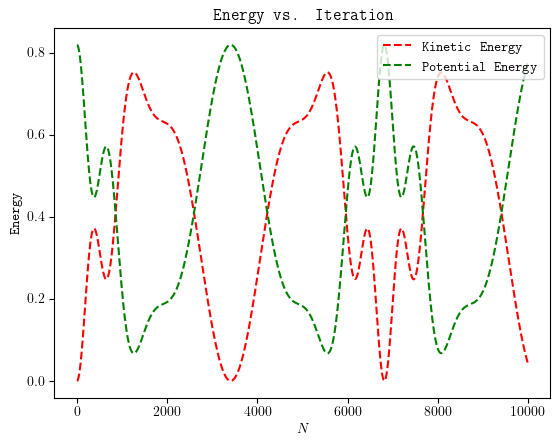

In [6]:
plotEnergies(enpath, "kp")

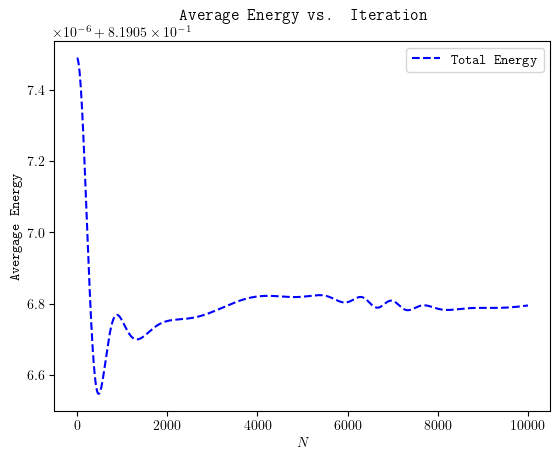

In [7]:
plotRunningAverageEnergies(enpath, "total")

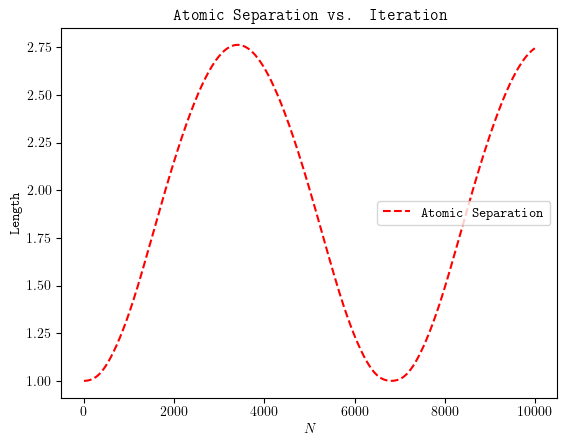

In [8]:
plotAtomicSeparations(aspath, "Atom1-Atom2")

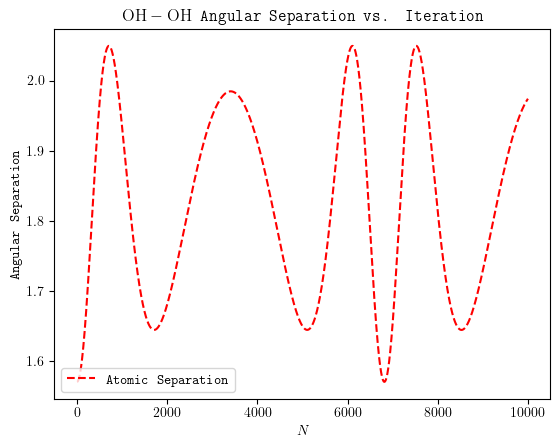

In [9]:
# Plot OH-OH Angular Separation
h1pData = pd.read_csv(appath / "Atom1.csv")
opData = pd.read_csv(appath / "Atom2.csv")
h2pData = pd.read_csv(appath / "Atom3.csv")
N = len(h1pData.index)
angularSeparations = np.zeros(N)
for i in range(0, N, 1):
    rij1 = opData.iloc[i].to_numpy() - h1pData.iloc[i].to_numpy()
    rij2 = opData.iloc[i].to_numpy() - h2pData.iloc[i].to_numpy()
    angularSeparations[i] = angle_between(rij1, rij2)
xs = np.arange(0, N, 1)
plt.plot(xs, angularSeparations, "r--", label = "Atomic Separation")
plt.xlabel("$N$")
plt.ylabel("Angular Separation")
plt.legend()
plt.title("$\mathrm{OH-OH}$ Angular Separation vs. Iteration")
plt.savefig(filepath / 'AngularSeparationVsIteration')
plt.show()

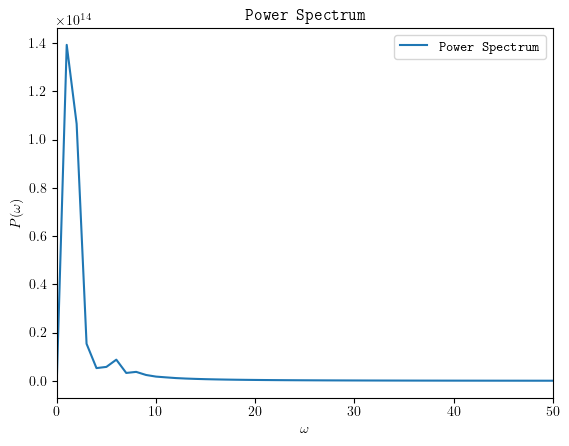

In [10]:
fileNames = molecularSystem.getAtomNames()
vacf = calculateVacf(avdir, fileNames)
powerSpectrum = calculatePowerSpectrum(vacf)
plotPowerSpectrum(avdir, powerSpectrum, [0.0, 50.0], False)

In [11]:
atomicSeparations = pd.read_csv(aspath)
energies = pd.read_csv(enpath)
vv = energies
print("Simulation Time:", round(endTime - startTime, 4), "seconds")
print("Initial Total Energy:", round(energies["TE"].iat[0], 4), "Hartree")
print("Final Total Energy:", round(energies["TE"].iat[-1], 4), "Hartree")
print("Average Total Energy:", round(np.mean(energies["TE"]), 4), u"\u00B1", round(np.std(energies["TE"]), 4), "Hartree")
print("Average OH Atomic Separation:", round(np.mean(atomicSeparations["Atom1-Atom2"]), 4), u"\u00B1", round(np.std(atomicSeparations["Atom1-Atom2"]), 4))
print("Average OH Angular Separation:", round(np.mean(angularSeparations), 4), u"\u00B1", round(np.std(angularSeparations), 4))

Simulation Time: 25.3556 seconds
Initial Total Energy: 0.8191 Hartree
Final Total Energy: 0.8191 Hartree
Average Total Energy: 0.8191 ± 0.0 Hartree
Average OH Atomic Separation: 1.8735 ± 0.6209
Average OH Angular Separation: 1.822 ± 0.1372
